# CatBoost pipeline

Attention à la version de numpy : 1.26.4 ( au lieu de 2.2.2) pour que ça fonctionne ici

In [1]:
import pandas as pd 

dataframe = pd.read_csv("SBAnational.csv", low_memory=False)

D'abord effectuer les conversions, avant de supprimer des colonnes

In [2]:
import conversion_functions as conv
import math

print (f"Before : {dataframe.shape[0]} lines")

explanable_X = pd.DataFrame(dataframe)

explanable_X["State"] = explanable_X["State"].apply(lambda x : conv.get_state_code(x))
explanable_X["NAICS"] = explanable_X["NAICS"].apply(lambda x : conv.get_NAICS_data(x))

explanable_X["ApprovalFY"] = explanable_X["ApprovalFY"].apply(lambda x : conv.get_ApprovalFY_data(x)) 
mean_dataframe = explanable_X[ explanable_X["ApprovalFY"] !=50]
mean_value = mean_dataframe["ApprovalFY"].mean()
explanable_X.loc[explanable_X['ApprovalFY'] == 50, 'ApprovalFY'] = math.ceil(mean_value)

explanable_X["NewExist"] = explanable_X["NewExist"].apply(lambda x : conv.get_NewExist_data(x)) 
explanable_X["FranchiseCode"] = explanable_X["FranchiseCode"].apply(lambda x : conv.get_FranchiseCode_data(x)) 

explanable_X = explanable_X.drop("UrbanRural", axis=1)

explanable_X["RevLineCr"] = explanable_X["RevLineCr"].apply(lambda x : conv.get_RevLineCr_data(x)) 
explanable_X["LowDoc"] = explanable_X["LowDoc"].apply(lambda x : conv.get_LowDoc_data(x)) 

explanable_X["GrAppv"] = explanable_X["GrAppv"].apply(lambda x : conv.get_GrAppv_value(x)) 
mean_dataframe = explanable_X[ explanable_X["GrAppv"] !=0]
mean_value = mean_dataframe["GrAppv"].mean()
explanable_X.loc[explanable_X['GrAppv'] == 0, 'ApprovalFY'] = math.ceil(mean_value)

explanable_X = explanable_X[ explanable_X["GrAppv"] !=0] 

explanable_X = explanable_X.drop("SBA_Appv", axis = 1)

explanable_X['MIS_Status'] = explanable_X.apply(lambda row: conv.predict_MIS_Status_data(row), axis=1 )
explanable_X["MIS_Status"] = explanable_X["MIS_Status"].apply(lambda x : conv.get_MIS_Status_data(x))

print (f"After : {explanable_X.shape[0]} lines")


Before : 899164 lines
After : 899164 lines


Ne supprimer les colonnes qu'après les conversions ( qui utilisent les colonnes supprimées )

In [3]:
explanable_X = explanable_X.drop('LoanNr_ChkDgt', axis=1)
explanable_X = explanable_X.drop('Name', axis=1)
explanable_X = explanable_X.drop('City', axis=1)
explanable_X = explanable_X.drop('Zip', axis=1)
explanable_X = explanable_X.drop('Bank', axis=1)
explanable_X = explanable_X.drop('BankState', axis=1)
explanable_X = explanable_X.drop('ApprovalDate', axis=1)
explanable_X = explanable_X.drop('ChgOffDate', axis=1) # (explicit end on simulation?) : included 
explanable_X = explanable_X.drop('DisbursementDate', axis=1)  
explanable_X = explanable_X.drop('DisbursementGross', axis=1)  
explanable_X = explanable_X.drop('BalanceGross', axis=1)  # 14 valeurs seulement différentes de zéro  ?
explanable_X = explanable_X.drop('ChgOffPrinGr', axis=1)

In [4]:
explanable_X["MIS_Status"].value_counts()

MIS_Status
P I F     741345
CHGOFF    157819
Name: count, dtype: int64

In [5]:
import MIS_Status_reference as mis_ref

# change data type in purpose to use precision as scoring metrix
explanable_X["MIS_Status"] = explanable_X["MIS_Status"].apply(lambda x : mis_ref.convert_MIS_Status_to_int(x) )
explanable_X["MIS_Status"].value_counts()

MIS_Status
1    741345
0    157819
Name: count, dtype: int64

In [6]:
import numpy
import pandas as pd 

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, LabelEncoder, LabelBinarizer, OneHotEncoder, Binarizer, FunctionTransformer, PolynomialFeatures,MinMaxScaler

def identity_operation(X) :
    return X

preprocessor = make_pipeline(  
    make_column_transformer(
        # LoanNr_ChkDgt, Name , City : excluded

        (FunctionTransformer(identity_operation, validate=False), ["State"]), 
        # Zip , Bank , BankState : excluded

        (FunctionTransformer(identity_operation, validate=False), ["NAICS"]), #included (2 first chars )
        
        # ApprovalDate : excluded
        (StandardScaler(), ["ApprovalFY"]),
        (StandardScaler(), ["Term"]), 
        (StandardScaler(), ["NoEmp"]),
        (StandardScaler(), ["NewExist"]),
        (StandardScaler(), ["CreateJob"]),
        (StandardScaler(), ["RetainedJob"]),
        (Binarizer(), ["FranchiseCode"]),
        #Binarizer("UrbanRural", threshold=1.5),

        (FunctionTransformer(identity_operation, validate=False), ["RevLineCr"]),
        (Binarizer(), ["LowDoc"]),
        # SimpleImputer("ChgOffDate"), # explicit end on simulation
        # DisbursementDate, DisbursementGross , BalanceGross ( 14 valeurs seulement différentes de zéro  ?)
        # MIS_Status : Excluded because it is Y !!!
        # ChgOffPrinGr : excluded
        (StandardScaler(), ["GrAppv"]), 
        #(StandardScaler(),["SBA_Appv"]),  
        remainder='passthrough'))

In [7]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from catboost import CatBoostClassifier, Pool
from scipy.stats import uniform, randint

# CatBoost prend en charge les données catégorielles nativement
categorical_features = ['State','NAICS', 'RevLineCr']

y = explanable_X['MIS_Status']
X = explanable_X.drop('MIS_Status', axis=1)

# Split en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Préparation des données pour CatBoost (en spécifiant les caractéristiques catégorielles)
# Convertir les données d'entraînement en un objet Pool pour indiquer les variables catégorielles (si nécessaire)
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)

test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)


In [8]:
#durée estimée : 20 min (100 fits de 12 secondes), réelle : 

# Initialize CatBoostClassifier
cat_boost_model = CatBoostClassifier(learning_rate=0.1, iterations=100, depth=6, cat_features=categorical_features)

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', cat_boost_model)])

# Define the hyperparameters grid for RandomizedSearch
param_dist = {
    'iterations': randint(100, 200),       # Number of boosting iterations
    'depth': randint(5, 9),              # Depth of the trees
    'learning_rate': uniform(0.2, 0.4),  # Learning rate
    'l2_leaf_reg': uniform(3, 12),        # L2 regularization coefficient
    'border_count': randint(32, 255),     # Number of splits for categorical features
    'bagging_temperature': uniform(0, 1), # Controls the randomness in bagging
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(cat_boost_model, param_distributions=param_dist, 
                                   n_iter=20, scoring='precision', 
                                   cv=5, verbose=1, n_jobs=-1)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Meilleurs paramètres trouvés : ", random_search.best_params_)
print("Meilleur score Precision : ", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	learn: 0.4712489	total: 709ms	remaining: 2m 1s
0:	learn: 0.4326912	total: 516ms	remaining: 1m 9s
0:	learn: 0.4330568	total: 899ms	remaining: 2m
0:	learn: 0.4739939	total: 703ms	remaining: 2m
1:	learn: 0.3447852	total: 856ms	remaining: 56.9s
0:	learn: 0.4773688	total: 748ms	remaining: 2m 6s
0:	learn: 0.4721268	total: 754ms	remaining: 2m 8s
0:	learn: 0.4341774	total: 939ms	remaining: 2m 5s
1:	learn: 0.3451383	total: 1.52s	remaining: 1m 40s
1:	learn: 0.3748861	total: 1.63s	remaining: 2m 18s
0:	learn: 0.4720445	total: 1.31s	remaining: 3m 44s
0:	learn: 0.4327829	total: 969ms	remaining: 2m 9s
2:	learn: 0.3060293	total: 1.67s	remaining: 1m 13s
0:	learn: 0.4331887	total: 601ms	remaining: 1m 20s
0:	learn: 0.4771949	total: 1.2s	remaining: 3m 22s
1:	learn: 0.3741904	total: 1.81s	remaining: 2m 33s
1:	learn: 0.3416666	total: 1.77s	remaining: 1m 58s
0:	learn: 0.4714343	total: 1.39s	remaining: 3m 57s
2:	learn: 0.3064131	total: 2.28s	rem

/home/nicolascassonnet/Documents/WORK/US_SBA_classification/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


20:	learn: 0.1848276	total: 15.8s	remaining: 2m 5s
5:	learn: 0.2929053	total: 5.42s	remaining: 2m 14s
131:	learn: 0.1416501	total: 1m 39s	remaining: 42.4s
121:	learn: 0.1480375	total: 1m 42s	remaining: 2.51s
8:	learn: 0.2543448	total: 7.37s	remaining: 1m 59s
22:	learn: 0.1716124	total: 15.7s	remaining: 1m 52s
132:	learn: 0.1416092	total: 1m 40s	remaining: 41.5s
131:	learn: 0.1416581	total: 1m 36s	remaining: 40.9s
3:	learn: 0.3479912	total: 3.17s	remaining: 1m 59s
123:	learn: 0.1488517	total: 1m 44s	remaining: 844ms
6:	learn: 0.2758936	total: 6s	remaining: 2m 6s
92:	learn: 0.1444019	total: 1m 7s	remaining: 1m 8s
21:	learn: 0.1821508	total: 16.6s	remaining: 2m 5s
122:	learn: 0.1478570	total: 1m 42s	remaining: 1.67s
9:	learn: 0.2462420	total: 8.04s	remaining: 1m 56s
133:	learn: 0.1415671	total: 1m 41s	remaining: 40.7s
93:	learn: 0.1443255	total: 1m 8s	remaining: 1m 8s
132:	learn: 0.1416580	total: 1m 36s	remaining: 40.1s
23:	learn: 0.1685535	total: 16.4s	remaining: 1m 52s
7:	learn: 0.26363

In [9]:
#durée estimée : 45 min (225 fits de 12 sec), réelle : - on est jamais arrivé à la fin du gridsearch sans erreur
# avec une seule valeur : 5 * 12 sec =>

#Meilleur score AUC :  0.9771748465313973 avec one_hot_encoder
# param_dist = {
#     'iterations': [191],       # Number of boosting iterations
#     'depth': [7],              # Depth of the trees
#     'learning_rate': [0.2621537355139263],  # Learning rate
#     'l2_leaf_reg': [9.620670562880655],        # L2 regularization coefficient
#     'bagging_temperature': [0.09440670531484197], # Controls the randomness in bagging
# }

#Meilleur score AUC : 0.9773692063410346
# param_dist = {
#     'iterations': [173], 
#     'depth': [8], 
#     'learning_rate':[0.2628238092699549],
#     'l2_leaf_reg': [4.642981495447009], 
#     'bagging_temperature': [0.6728806036024608], 
#     'border_count': [106]
# }

#Meilleur score Precision :  0.9616689295201551
bm_iterations = 184
bm_depth = 6
bm_learning_rate = 0.28119761253249864
bm_l2_leaf_reg = 7.32060164065551
bm_bagging_temperature = 0.22998810110951384
bm_border_count = 240

best_params_random = random_search.best_params_
if random_search.best_score_ > 0.9616689295201551 :
    bm_iterations = best_params_random['iterations']
    bm_depth = best_params_random['depth'] 
    bm_learning_rate = best_params_random['learning_rate']
    bm_l2_leaf_reg = best_params_random['l2_leaf_reg']
    bm_bagging_temperature = best_params_random['bagging_temperature']
    bm_border_count = best_params_random['border_count']

# Initialize CatBoostClassifier
cat_boost_model = CatBoostClassifier(iterations = bm_iterations, learning_rate=bm_learning_rate, depth=bm_depth, cat_features=categorical_features)

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', cat_boost_model)])

# Utilisation dans un gridsearch
param_grid = {
    'iterations': [bm_iterations],
    'depth': [bm_depth],
    'learning_rate': [bm_learning_rate],
    'l2_leaf_reg': [bm_l2_leaf_reg], 
    'bagging_temperature': [bm_bagging_temperature], 
    'border_count': [bm_border_count],
}

# Créer le GridSearchCV avec le param_grid
grid_search = GridSearchCV(estimator=cat_boost_model, param_grid=param_grid, 
                           scoring='precision', cv=5, n_jobs=-1, verbose=1)

# Ajuster GridSearchCV
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres trouvés par GridSearch : ", grid_search.best_params_)
print("Meilleur score precision de GridSearch : ", grid_search.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.4304686	total: 254ms	remaining: 47.6s
1:	learn: 0.3338464	total: 394ms	remaining: 36.6s
0:	learn: 0.4313924	total: 254ms	remaining: 47.5s
2:	learn: 0.2841918	total: 638ms	remaining: 39.3s
0:	learn: 0.4332934	total: 361ms	remaining: 1m 7s
1:	learn: 0.3348799	total: 674ms	remaining: 1m 2s
0:	learn: 0.4306684	total: 580ms	remaining: 1m 48s
0:	learn: 0.4308278	total: 590ms	remaining: 1m 50s
3:	learn: 0.2535483	total: 1s	remaining: 46.1s
1:	learn: 0.3367566	total: 717ms	remaining: 1m 6s
1:	learn: 0.3339959	total: 938ms	remaining: 1m 27s
2:	learn: 0.2851424	total: 1.08s	remaining: 1m 6s
4:	learn: 0.2370964	total: 1.35s	remaining: 49.3s
2:	learn: 0.2866177	total: 1.02s	remaining: 1m 2s
1:	learn: 0.3355302	total: 1.01s	remaining: 1m 33s
2:	learn: 0.2842467	total: 1.33s	remaining: 1m 22s
3:	learn: 0.2541855	total: 1.46s	remaining: 1m 7s
5:	learn: 0.2212562	total: 1.71s	remaining: 51.9s
2:	learn: 0.2831293	total: 1.38s	remain

Nombre d'échantillons du test : 269750
Test score : 96.37%
AUC : 97.74%
Accuracy : 94.83%
Precision : 96.37% (check=96.37%, FN=8170)
Recall : 97.40% (check=97.40%, FP=5772)
Macro F1 Score : 90.89%
Matrice de confusion :
[[ 39176   8170]
 [  5772 216632]]


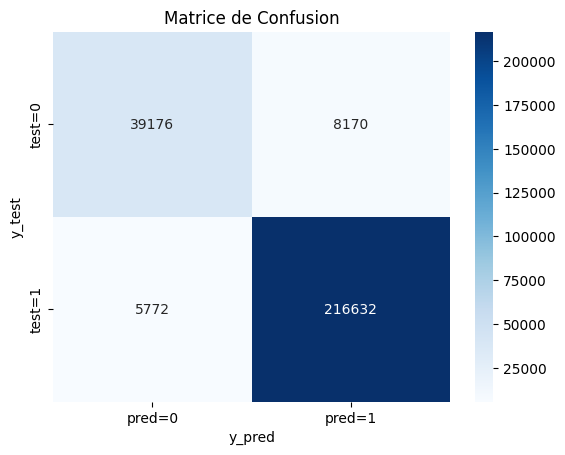

              precision    recall  f1-score   support

           0       0.87      0.83      0.85     47346
           1       0.96      0.97      0.97    222404

    accuracy                           0.95    269750
   macro avg       0.92      0.90      0.91    269750
weighted avg       0.95      0.95      0.95    269750



In [10]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import MIS_Status_reference as mis_ref

num_ech = y_test.shape[0]
print(f"Nombre d'échantillons du test : {num_ech}")

test_score = grid_search.score(X_test, y_test)
#test_score = random_search.score(X_test, y_test)
print(f"Test score : {test_score * 100:.2f}%")

# Prédictions sur le jeu de test

#y_pred = random_search.predict(X_test)
y_pred = grid_search.predict(X_test)


df_y_test = pd.DataFrame(y_test)
#df_y_test["MIS_Status"] = df_y_test["MIS_Status"].apply(lambda x : mis_ref.convert_MIS_Status_to_int(x) )

df_y_pred = pd.DataFrame(y_pred, columns=["MIS_Status"])
#df_y_pred["MIS_Status"] = df_y_pred["MIS_Status"].apply(lambda x : mis_ref.convert_MIS_Status_to_int(x) )

#ligne 1 : pred_value = 0
conf_mat_TN = 0
conf_mat_FP = 0

#ligne 2 : pred_value = 1
conf_mat_FN = 0
conf_mat_TP = 0

for index in range(num_ech) :
    test_value = df_y_test.iloc[index, 0]
    pred_value = df_y_pred.iloc[index, 0]
    if pred_value == 0 :
        if test_value == 0 : conf_mat_TN +=1
        else : conf_mat_FP += 1
    else :
        if test_value == 0: conf_mat_FN += 1
        else : conf_mat_TP += 1

check_recall = conf_mat_TP / (conf_mat_FP+ conf_mat_TP)
check_precision = conf_mat_TP / (conf_mat_FN+ conf_mat_TP)

# Évaluation du modèle
accuracy = accuracy_score(df_y_test, df_y_pred)
precision = precision_score(df_y_test, df_y_pred)
recall = recall_score(df_y_test, df_y_pred)
macro_f1 = f1_score(df_y_test, df_y_pred, average='macro')
conf_matrix = confusion_matrix(df_y_test, df_y_pred)

# Prédire sur l'ensemble de test
#y_pred_proba = random_search.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Calculer l'AUC sur l'ensemble de test
auc = roc_auc_score(y_test, y_pred_proba)

# Afficher les résultats
print(f"AUC : {100*auc:.2f}%")
print(f"Accuracy : {100*accuracy:.2f}%")
print(f"Precision : {100*precision :.2f}% (check={100*check_precision:.2f}%, FN={conf_mat_FN})")
print(f"Recall : {100*recall:.2f}% (check={100*check_recall:.2f}%, FP={conf_mat_FP})")
print(f"Macro F1 Score : {100*macro_f1:.2f}%")
print("Matrice de confusion :")
print(conf_matrix)


# Affichage avec Seaborn (optionnel)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['pred=0', 'pred=1'], yticklabels=['test=0', 'test=1'])
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.title('Matrice de Confusion')
plt.show()

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

# # # Afficher la matrice de confusion
# # print("Matrice de confusion :\n", conf_matrix)
# # plt.figure(figsize=(6, 6))
# # plot_confusion_matrix(random_search.best_estimator_, X_test, y_test, cmap=plt.cm.Blues)
# # plt.title('Matrice de Confusion')
# # plt.show()
